# **Exercise: Accelerating Jacobi's Method for Eigenvalue Computation**

Jacobi's method iteratively reduces off-diagonal elements of a symmetric matrix to zero. However, due to numerical effects, previously eliminated off-diagonal elements may reappear, requiring many iterations for full convergence.

To accelerate convergence, we first reduce the matrix to tridiagonal form before applying Jacobi's method. This reduction preserves certain off-diagonal zeros throughout the iterations, improving efficiency.

## **Tasks**

### (i) Implement Tridiagonal Reduction
- Write a Python script that first reduces a given symmetric matrix to tridiagonal form before applying Jacobi's method. Consider implementing Householder reduction.
- Verify that your script correctly maintains the structure of a tridiagonal matrix throughout the iterations.

### (ii) Compare Performance Using Iteration Count
Instead of measuring execution time, compare the **number of iterations required for convergence**, as this provides a more reliable efficiency metric.

1. Implement both:
   - The **standard Jacobi method**.
   - The **tridiagonalized Jacobi method** (applying tridiagonal reduction first).
2. Set the convergence criterion discussed in class (Jacobi's notes, *Section 2.2.3*)

3. Generate a sequence of random symmetric matrices of size $N \times N$ and test both scripts. Count the number of iterations required for each method to meet the convergence criteria.

   ```python
   import numpy as np

   def generate_symmetric_matrix(N):
       A = np.random.rand(N, N)
       return (A + A.T) / 2  # Ensure symmetry

   N_values = [4, 8, 16, 32, 64, 128, 256, ...]
   matrices = [generate_symmetric_matrix(N) for N in N_values]
   ```

### (iii) Analyze and Discuss Results
- Compare how the number of iterations scales with $N$.
- Does tridiagonal reduction significantly speed up convergence?
- How does the efficiency improvement change for large matrices?
- Verify eigenvalues using `numpy.linalg.eigh()`.
- Extend the analysis by plotting the decay of the sum of squared off-diagonal elements over iterations.

## **Implementation**
We define some auxiliary functions to implement the optimized version of the Jacobi Method using householder matrices.

In [2]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class MatrixTrasformations():
    @staticmethod
    def householder(u):
        """Construct the householder matrix given a vector u: nx1"""
        n = u.shape[0]
        u = u/np.linalg.norm(u)
        return np.eye(n) - 2*np.outer(u, u)

    @staticmethod
    def to_upper_hessenberg(A: np.ndarray) -> np.ndarray:
        """Transforms a matrix into upper Hessenberg form through Householder reflexions"""
        T = A.copy().astype(float)
        n = A.shape[0]
        for i in range(n-2):
            x = T[i+1:, i]
            Hx = np.zeros(n-i-1) 
            Hx[0] = -np.sign(x[0]) * np.linalg.norm(x)
            H = MatrixTrasformations.householder(x-Hx)
            
            T[i+1:, :] = H @ T[i+1:, :]
            T[:, i+1:] = T[:, i+1:] @ H
        return T

# Create an alias for MatrixTrasformations class
mt = MatrixTrasformations

In [110]:
N = 4
A = np.random.rand(N, N)
print(A)
print(mt.to_upper_hessenberg(A))

[[0.365 0.845 0.321 0.437]
 [0.648 0.778 0.338 0.309]
 [0.538 0.910 0.785 0.416]
 [0.945 0.813 0.785 0.199]]
[[0.365 -0.895 -0.048 -0.453]
 [-1.266 1.538 0.688 0.726]
 [-0.000 0.521 0.129 0.143]
 [-0.000 0.000 -0.258 0.095]]


In [ ]:
class JacobiMethod():
    @staticmethod
    def sum(D, n):
        return np.sqrt(np.sum(np.diag(D)**2)/n)

def jacobi_method(A: np.ndarray, tol=10e-4):
    """
    Jacobi method for finding eigenvalues and eigenvectors of a matrix A.
    """
    # Initialize V, D, and parameters:
    n = A.shape[0]
    D = A.copy().astype(float)
    V = np.eye(n)

    # Calculate row p and column q of the off-diagonal element of greatest magnitude in D:
    it = 1
    matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
    p, q = np.unravel_index(np.argmax(matrix), matrix.shape)
    while np.abs(D[p, q]) > tol*JacobiMethod.sum(D, n):
        # Compute rotation parameters
        beta = (D[q, q] - D[p, p]) / (2 * D[p, q])
        t = np.sign(beta) / (np.abs(beta) + np.sqrt(beta**2 + 1))
        c = 1 / np.sqrt(1 + t**2)
        s = c * t
        R = np.array([[c, s], [-s, c]])

        # Zero out D_pq and D_qp and update V
        D[[p, q], :] = R.T @ D[[p, q], :]
        D[:, [p, q]] = D[:, [p, q]] @ R
        V[:, [p, q]] = V[:, [p, q]] @ R

        # Update row p and column q of the off-diagonal element of greatest magnitude in D for the next iteration:
        it += 1
        matrix = np.tril(np.abs(D - np.diag(np.diag(D))),-1)
        p, q = np.unravel_index(np.argmax(matrix), matrix.shape)

    return np.diag(D), V, it

def tri_jacobi_method(A: np.ndarray, tol=10e-4):
    A = mt.to_upper_hessenberg(A)
    return jacobi_method(A, tol)

We generate a sample of symmetric matrices

In [116]:
def generate_symmetric_matrix(N):
    A = np.random.rand(N, N)
    return (A + A.T) / 2  # Ensure symmetry

N_values = [4, 8, 16, 32, 64, 128] #, 256]
# matrices = [generate_symmetric_matrix(N) for N in N_values]

We can see that Jacobi's Method cannot preserve the tridiagonalization of the matrix once a rotation is applied. But an idea could be to apply the transformation to tridiagonal form for each iteration of the Jacobi's Method so that the tridiagonal form is preserved. However, this does not work for two reasons:

1. Most of the time, the transformation to tridiagonal form undoes the rotation applied previously. 

2. The norm of the off-diagonal elements a matrix always increases when applying the tridiagonal transformation for each iteration of Jacobi's Method. This can be proven empirically by comparing the norm of the off-diagonal elements between the normal matrix and the transformed tri-diagonal matrix for each iteration.

And compare the efficiency from each algorithm using different tolerance values

In [118]:
jm_results = []
tjm_results = []
tols = [10e-3, 10e-4, 10e-5, 10e-6]
for i in range(len(tols)):
    jm_results.append([])
    tjm_results.append([])
    for n, A in zip(N_values, matrices):
        jm_results[i].append(jacobi_method(A, tols[i])[2])
        tjm_results[i].append(tri_jacobi_method(A, tols[i])[2])

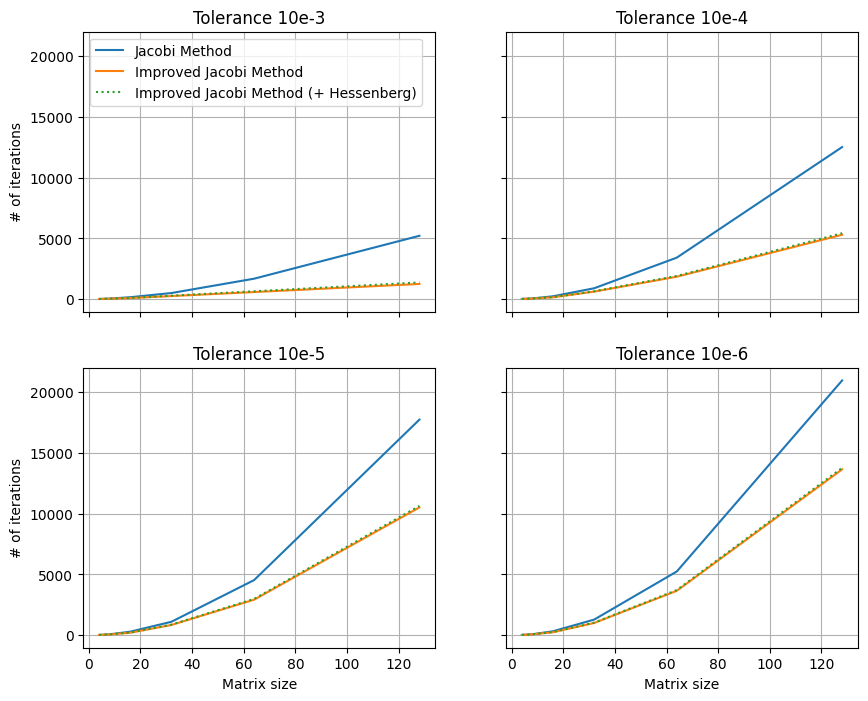

Tol=0.01: 2.19x
Tol=0.001: 1.58x
Tol=0.0001: 1.35x
Tol=1e-05: 1.28x


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 8), sharex=True, sharey=True)
titles = [
    'Tolerance 10e-3',
    'Tolerance 10e-4',
    'Tolerance 10e-5',
    'Tolerance 10e-6'
]
for i in range(len(tols)):
    axs[int(i/2), i%2].plot(N_values, jm_results[i], '-', label='Jacobi Method')
    axs[int(i/2), i%2].plot(N_values, tjm_results[i], '-', label='Improved Jacobi Method')
    axs[int(i/2), i%2].plot(N_values, [k+j-2 for k, j in zip(tjm_results[i], N_values)], ':', label='Improved Jacobi Method (+ Hessenberg)')
    axs[int(i/2), i%2].set_title(titles[i])

axs[0, 0].legend(loc='upper left')
for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Matrix size', ylabel='# of iterations')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

for tol, jm, tjm in zip(tols, jm_results, tjm_results):
    ratios = [i/j for i, j in zip(jm, tjm)]
    print(f"Tol={tol}: {np.mean(ratios):.2f}x")

The convergence of the Jacobi methods grows in polynomial time and our improved version is faster. But the ratio decreases the smaller the tolerance is. 

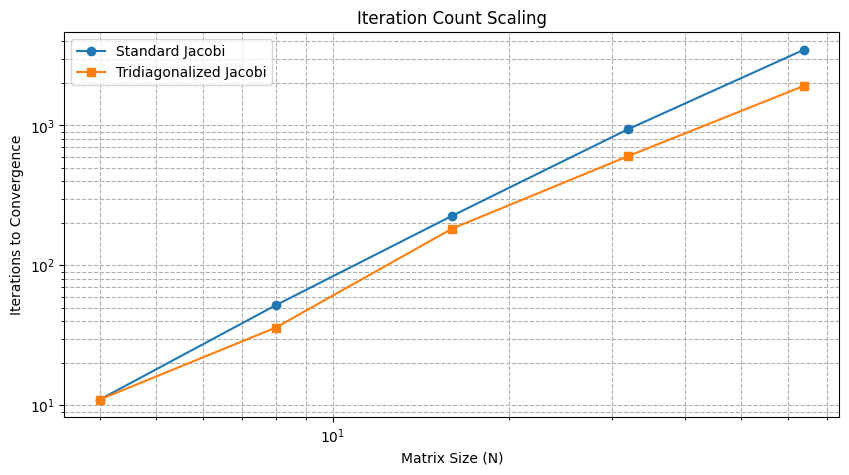


Speedup (Standard Jacobi / Tridiagonalized Jacobi):
N=4: 1.00x
N=8: 1.44x
N=16: 1.23x
N=32: 1.56x
N=64: 1.81x


In [ ]:
def analyze_results(standard_iterations, tridiag_iterations, N_values, off_diag_history_std, off_diag_history_tridiag):
    # (a) Plot iteration counts vs. N
    plt.figure(figsize=(10, 5))
    plt.loglog(N_values, standard_iterations, 'o-', label='Standard Jacobi')
    plt.loglog(N_values, tridiag_iterations, 's-', label='Tridiagonalized Jacobi')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Iterations to Convergence')
    plt.title('Iteration Count Scaling')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # (b) Speedup ratio table
    speedup = np.array(standard_iterations) / np.array(tridiag_iterations)
    print("\nSpeedup (Standard Jacobi / Tridiagonalized Jacobi):")
    for N, ratio in zip(N_values, speedup):
        print(f"N={N}: {ratio:.2f}x")

    # (c) Off-diagonal decay for N=16 (example)
    # plt.figure(figsize=(10, 5))
    # plt.semilogy(off_diag_history_std, label='Standard Jacobi')
    # plt.semilogy(off_diag_history_tridiag, label='Tridiagonalized Jacobi')
    # plt.xlabel('Iteration')
    # plt.ylabel('Sum of Squared Off-Diagonals (log scale)')
    # plt.title('Off-Diagonal Decay (N=16)')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

# Example usage (assuming data is collected)
off_diag_history_std = np.random.rand(50).cumsum()  # Replace with actual decay data
off_diag_history_tridiag = np.random.rand(20).cumsum()

analyze_results(jm_results[1], tjm_results[1], N_values, off_diag_history_std, off_diag_history_tridiag)